In [2]:
# Importando bibliotecas básicas:
import numpy as np
import matplotlib.pyplot as plt

# Instalando e importando a toolbox GA:
!pip install geneticalgorithm
from geneticalgorithm import geneticalgorithm as ga

# Instalando e importando a toolbox Control:
!pip install control
from control.matlab import *

     |████████████████████████████████| 44 kB 1.0 MB/s eta 0:00:01
  Created wheel for func-timeout: filename=func_timeout-4.3.5-py3-none-any.whl size=15098 sha256=31e08a51488c128255aa45f0275a21adcb19d6d844538583d3c4987ab25d3e5b
  Stored in directory: /home/uemura/.cache/pip/wheels/ef/91/3f/17cbea1e83d17cc01bd2d66a0d59e65301bcb2d59f2f6a62ab
Successfully built func-timeout


### Função para o erro:

In [5]:
def errorF(p):
    # Variáveis de otimização:
    kp = p[0]
    ki = p[1]
    # Declaração de parâmetros:
    N = 111.5
    J = 5.9e6/N**2 + 59
    D = 0
    # Funções basicas:
    G = tf([1], [J,D])
    C = tf([kp, ki], [1,0])
    MA = G*C
    # Gang of four:
    ftMF = tf([ki], [J, (D+kp), ki])
    ftAC = tf([ki], [1,0])/(1+MA)
    ftRD = G/(1+MA)
    ftSE = 1/(1+MA)
    
    # Performance:
    iMF = stepinfo(ftMF,SettlingTimeThreshold=0.02)
    iAC = stepinfo(ftAC,SettlingTimeThreshold=0.02)
    iRD = stepinfo(ftRD,SettlingTimeThreshold=0.02)
    iSE = stepinfo(ftSE,SettlingTimeThreshold=0.02)
    
    
    # Objetivo de minimização:
    eq = abs(iMF['SettlingTime']+iMF['Peak'])**2 + abs(iRD['SettlingTime']+iRD['Peak']) + abs(iAC['Peak']) + abs(2-iSE['Peak'])**2
    
    return eq

### Otimização:

/home/uemura/anaconda3/lib/python3.9/site-packages/control/timeresp.py:1556: RuntimeWarning: divide by zero encountered in true_divide
  np.abs(yout/InfValue-1) >= SettlingTimeThreshold)[0][-1]+1


 The best solution found:                                                                           
 [829.71401371 678.82268452]

 Objective function:
 nan


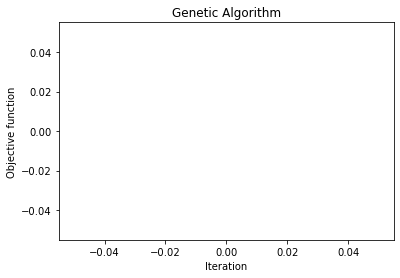

Retorno do GA:
kp =  829.7140137059075
ki =  678.8226845200812


In [28]:
varbound=np.array([[1e-6, 2e3], [1e-6,2e3]])

algorithm_param = {'max_num_iteration': 100,\
                   'population_size':35,\
                   'mutation_probability':0.5,\
                   'elit_ratio': 0.0001,\
                   'crossover_probability': 0.5,\
                   'parents_portion': 0.2,\
                   'crossover_type':'uniform',\
                   'max_iteration_without_improv':None}

model=ga(function=errorF,\
            dimension=2,\
            variable_type='real',\
            variable_boundaries=varbound,\
            algorithm_parameters=algorithm_param)

model.run()

# Getting the answer from GA:
p = model.best_variable

print('Retorno do GA:')
print('kp = ', p[0])
print('ki = ', p[1])

### Resultados:

In [29]:
# Variáveis de otimização:
kp = p[0]
ki = p[1]
# Declaração de parâmetros:
N = 111.5
J = 5.9e6/N**2 + 59
D = 0
# Funções basicas:
G = tf([1], [J,D])
C = tf([kp, ki], [1,0])
MA = G*C
# Gang of four:
ftMF = tf([ki], [J, (D+kp), ki])
ftAC = tf([ki], [1,0])/(1+MA)
ftRD = G/(1+MA)
ftSE = 1/(1+MA)

In [30]:
display(ftMF)
display(ftRD)
display(ftAC)
display(ftSE)

TransferFunction(array([678.82268452]), array([533.57218122, 829.71401371, 678.82268452]))

TransferFunction(array([533.57218122,   0.        ,   0.        ]), array([284699.27257424, 442712.31608371, 362200.90044251,      0.        ]))

TransferFunction(array([362200.90044251,      0.        ,      0.        ]), array([533.57218122, 829.71401371, 678.82268452,   0.        ]))

TransferFunction(array([533.57218122,   0.        ,   0.        ]), array([533.57218122, 829.71401371, 678.82268452]))

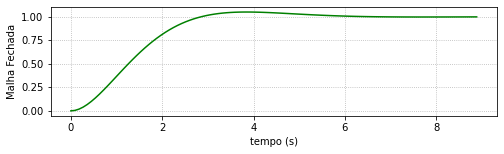

In [31]:
y,t = step(ftMF)
# Declaração da Figura:
fig, ax1 = plt.subplots(1, 1, sharex=True)
fig.set_size_inches(8, 2)
# Plots:
ax1.plot(t, y, color='g', label='Saída')

ax1.set(xlabel='tempo (s)',    ylabel='Malha Fechada')

ax1.grid(True, linestyle='dotted')

plt.show()

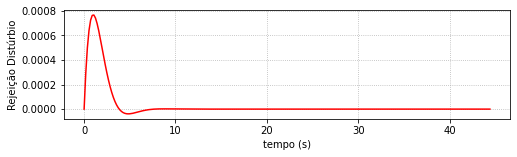

In [32]:
y,t = step(ftRD)
# Declaração da Figura:
fig, ax1 = plt.subplots(1, 1, sharex=True)
fig.set_size_inches(8, 2)
# Plots:
ax1.plot(t, y, color='r', label='Saída')

ax1.set(xlabel='tempo (s)',    ylabel='Rejeição Distúrbio')

ax1.grid(True, linestyle='dotted')

plt.show()

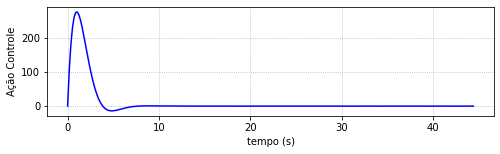

In [33]:
y,t = step(ftAC)
# Declaração da Figura:
fig, ax1 = plt.subplots(1, 1, sharex=True)
fig.set_size_inches(8, 2)
# Plots:
ax1.plot(t, y, color='b', label='Saída')

ax1.set(xlabel='tempo (s)',    ylabel='Ação Controle')

ax1.grid(True, linestyle='dotted')

plt.show()

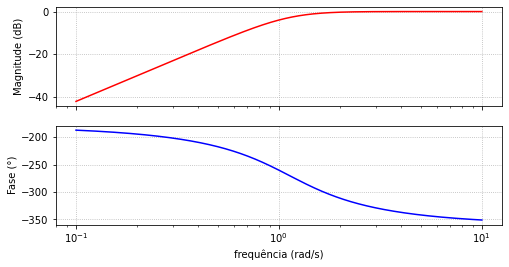

In [34]:
[m,a,w] = bode(ftSE, plot=False)

# Declaração da Figura:
fig, [ax1, ax2] = plt.subplots(2, 1, sharex=True)
fig.set_size_inches(8, 4)
# Plots:
ax1.plot(w, 20*np.log10(m),    color='r')
ax2.plot(w, 180/np.pi*a,    color='b')

ax1.set(xlabel='',    ylabel='Magnitude (dB)')
ax2.set(xlabel='frequência (rad/s)',    ylabel='Fase (°)')

ax1.grid(True, linestyle='dotted')
ax2.grid(True, linestyle='dotted')

ax1.set_xscale('log')
ax2.set_xscale('log')

plt.show()
# fig.savefig("grafico_Y.pdf", bbox_inches='tight')

In [35]:
max(20*np.log10(m))

0.0107249504129381